In [1]:
!nvidia-smi

Tue Aug 10 20:07:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   32C    P0    39W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:1B:00.0 Off |                    0 |
| N/A   

In [28]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from rich import print

In [29]:
os.getcwd()

'/gpfs/home/kahngh01/workspaces/self-supervised-learning'

In [30]:
from datasets.cifar import CIFAR10
from datasets.transforms import MoCoAugment
from models.backbone import ResNetBackbone
from models.head import MLPHead
from tasks.moco import MemoryQueue
from tasks.clapp import CLAPP

In [31]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = torch.cuda.current_device()
print(f"GPU: {DEVICE}")

GPU: 0

In [32]:
DEVICE = 'cpu'

In [33]:
train_transform = MoCoAugment(size=(32, 32), data='cifar10')
train_set       = CIFAR10('./data/cifar10', train=True, transform=train_transform)
test_set        = CIFAR10('./data/cifar10', train=False, transform=train_transform)
train_loader    = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader     = DataLoader(test_set, batch_size=64, shuffle=True)


In [34]:
CKPT_PATH = 'checkpoints/cifar10/clapp/resnet50/basic/ckpt.1000.pth.tar'
if os.path.exists(CKPT_PATH):
    config_file = os.path.join(os.path.dirname(CKPT_PATH), 'configs.json')
    with open(config_file, 'r') as fp:
        config = json.load(fp)
    print(config)


{
    'hash': '2021-08-05_04:11:54',
    'gpus': [0, 1, 2, 3],
    'num_nodes': 1,
    'node_rank': 0,
    'dist_url': 'tcp://127.0.0.1:3500',
    'dist_backend': 'nccl',
    'data_root': './data',
    'data': 'cifar10',
    'input_size': 32,
    'augmentation': 'torchvision',
    'backbone_type': 'resnet50',
    'resume': None,
    'epochs': 1000,
    'batch_size': 256,
    'num_workers': 8,
    'optimizer': 'sgd',
    'learning_rate': 0.12,
    'weight_decay': 0.0001,
    'cosine_warmup': 10,
    'cosine_cycles': 1,
    'cosine_min_lr': 0.005,
    'mixed_precision': False,
    'checkpoint_root': './checkpoints/',
    'save_every': 100,
    'enable_wandb': True,
    'projector_type': 'mlp',
    'projector_dim': 128,
    'num_negatives': 4096,
    'temperature': 0.2,
    'pseudo_temperature': 0.1,
    'key_momentum': 0.999,
    'pseudo_momentum': 0.999,
    'query_augment': 'rand',
    'key_augment': 'moco',
    'pseudo_augment': 'moco',
    'rand_k': 5,
    'contrast_mode': 'batch',
    'normalize': 'softmax',
    'threshold': 0.5,
    'split_bn': False,
    'ramp_up': 50,
    'knn_k': [5, 200],
    'num_gpus_per_node': 4,
    'world_size': 4,
    'distributed': True,
    'task': 'clapp',
    'model_name': 'resnet50',
    'checkpoint_dir': './checkpoints/cifar10/clapp/resnet50/2021-08-05_04:11:54'
}

In [37]:
encoder = ResNetBackbone('resnet50', data='cifar10')
head = MLPHead(in_channels=2048, num_features=config['projector_dim'])
teacher = nn.Sequential(); teacher.add_module('encoder', encoder); teacher.add_module('head', head)
queue = MemoryQueue(size=(config['projector_dim'], config['num_negatives']), device=DEVICE)

In [38]:
# Load teacher model & memory queue
ckpt = torch.load(CKPT_PATH, map_location='cpu')
teacher.load_state_dict(ckpt['net_ps'])
queue.load_state_dict(ckpt['queue'])
teacher.to(DEVICE)
queue.to(DEVICE)

MemoryQueue()

In [39]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [78]:
@torch.no_grad()
def select_pseudo_positives(batch: dict, net: nn.Module, queue: MemoryQueue, threshold: float, device: int):
    """Add function docstring."""
    
    net.train()
    
    idx = batch['idx']
    x = batch['x'].to(device)
    y = batch['y'].to(device)
    z = F.normalize(net(x), dim=1)  # (B, 128)

    logits_of_negatives = torch.einsum('bf,fk->bk', [z, queue.buffer])
    selection_probs = F.softmax(logits_of_negatives.div(0.1), dim=0)
    selected_pairs = selection_probs.ge(threshold).nonzero(as_tuple=False)
    
    #above_threshold = selection_probs.ge(threshold)
    #is_correct = y.view(-1, 1).eq(queue.labels.view(1, -1))
    #num_correct = is_correct.masked_select(above_threshold).sum()
    #return torch.true_divide(num_correct, above_threshold.sum())

    labels_of_batch = y[selected_pairs[:, 0]].detach().cpu()
    labels_of_queue = queue.labels[selected_pairs[:, 1]].detach().cpu()

    correct = labels_of_batch.eq(labels_of_queue).sum()
    return correct.div(len(selected_pairs)).item()



In [80]:
for i, batch in enumerate(train_loader):
    precision_ = select_pseudo_positives(batch, teacher, queue, threshold=0.7, device=DEVICE)
    print(f"{precision_:.3f},", end=' ')
    if i > 10:
        break

nan,

nan,

nan,

nan,

nan,

nan,

nan,

nan,

nan,

nan,

nan,

nan,

In [32]:
@torch.no_grad()
def extract_features(data_loader, encoder: nn.Module, ckpt: str, device: int):
    
    encoder.load_weights_from_checkpoint(ckpt, key='encoder')
    encoder.to(device)
    encoder.eval()
    
    Z = []
    for i, batch in enumerate(data_loader):
        x = batch['x'].to(device)
        z = F.adaptive_avg_pool2d(encoder(x), output_size=1).squeeze()
        z = F.normalize(z, dim=1)
        Z += [z]
        
    encoder.to('cpu')
    
    return torch.cat(Z, dim=0)

In [33]:
Z = extract_features(test_loader, encoder, ckpt=CKPT, device=DEVICE)

In [20]:
# MoCo
db_score = davies_bouldin_score(Z.cpu().numpy(), np.array(test_set.targets))
ch_score = calinski_harabasz_score(Z.cpu().numpy(), np.array(test_set.targets))
print(f"Davies-Bouldin Score: {db_score:.2f}")
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

Davies-Bouldin Score: 5.14
Calinski-Harabasz Score: 122.33


In [34]:
# Proposed Method
db_score = davies_bouldin_score(Z.cpu().numpy(), np.array(test_set.targets))
ch_score = calinski_harabasz_score(Z.cpu().numpy(), np.array(test_set.targets))
print(f"Davies-Bouldin Score: {db_score:.2f}")
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

Davies-Bouldin Score: 5.02
Calinski-Harabasz Score: 131.02


In [35]:
from cuml.manifold import TSNE

In [38]:
%%time
tsne = TSNE(n_components=2, perplexity=30, n_iter=20000, random_state=2020, output_type='numpy')
H = tsne.fit_transform(Z)

CPU times: user 9.9 s, sys: 8.29 s, total: 18.2 s
Wall time: 18.2 s


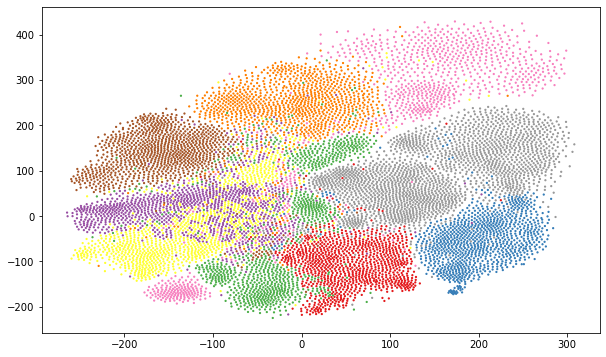

In [39]:
# CLaPP
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(H[:, 0], H[:, 1], c=np.array(test_set.targets), s=1.5, cmap=plt.cm.Set1)
plt.show(fig)

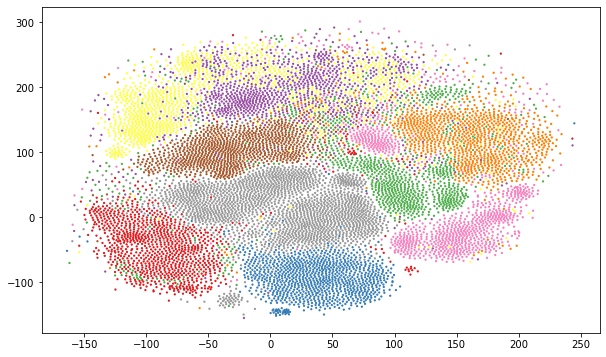

In [25]:
# MoCo
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(H[:, 0], H[:, 1], c=np.array(test_set.targets), s=1.5, cmap=plt.cm.Set1)
plt.show(fig)